In [ ]:
import torch, gc
import os
import torchvision
from zipfile import ZipFile
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as tt
from torch.utils.data import random_split
from torchvision.utils import make_grid
import matplotlib
from torchvision.datasets.utils import download_url
import matplotlib.pyplot as plt

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# g_path = '/content/drive/MyDrive/gender_data.zip'
# with ZipFile(g_path,'r') as zip:
#     zip.extractall(path='/')

In [ ]:
dir_path = '/gender_data'

In [ ]:
stats = ((0.6525, 0.4831, 0.405),(0.2351, 0.2073, 0.1984))

In [ ]:
train_tfms = tt.Compose([tt.RandomHorizontalFlip(),
                        # tt.Grayscale(),
                        tt.ColorJitter(brightness=0.3,contrast=0.2,saturation=0.1,hue=0.2),
                        tt.ToTensor(),
                        tt.Normalize(*stats,inplace=True)])
test_tfms = tt.Compose([tt.ToTensor(),tt.Normalize(*stats)])


In [ ]:
train_ds = ImageFolder(dir_path+'/train',train_tfms)
test_ds = ImageFolder(dir_path+'/test',test_tfms)
len(train_ds),len(test_ds)

(46400, 11600)

In [ ]:
batch_size = 64

In [ ]:
train_dl = DataLoader(train_ds,batch_size,shuffle=True,num_workers=3,pin_memory=True)
test_dl = DataLoader(test_ds,batch_size*2,num_workers=3,pin_memory=True)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
def denormalize(images,means,stds):
    means = torch.tensor(means).reshape(1,3,1,1)
    stds = torch.tensor(stds).reshape(1,3,1,1)
    return images*stds+means

In [ ]:
for images,labels in train_dl:
    print(images.shape)
    break

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


torch.Size([64, 3, 64, 64])


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [ ]:
class Resnet(nn.Module):
    def __init__(self,):
        super().__init__()
        #3x64x64
        self.conv15 = nn.Conv2d(3,15,kernel_size=3,stride=1,padding=1)#15x64x64
        self.norm15 = nn.BatchNorm2d(15)
        self.relu15 = nn.ReLU()
        self.conv30 = nn.Conv2d(15,30,kernel_size=3,stride=1,padding=1)#30x64x64
        self.norm30 = nn.BatchNorm2d(30)
        self.relu30 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(2,2)

        self.res1 = nn.Conv2d(30,30,kernel_size=3,stride=1,padding=1)#30x32x32

        self.conv30b = nn.Conv2d(30,30,kernel_size=3,padding=1,stride=1)#30x32x32
        self.relu30b = nn.ReLU()
        self.conv60 = nn.Conv2d(30,60,kernel_size=3,stride=1,padding=1)#60x32x32
        self.norm60 = nn.BatchNorm2d(60)
        self.relu60 = nn.ReLU()
        self.conv120 = nn.Conv2d(60,120,kernel_size=3,stride=1,padding=1)#120x32x32
        self.norm120 = nn.BatchNorm2d(120)
        self.relu120 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(2,2)

        self.res2 = nn.Conv2d(120,120,kernel_size=3,padding=1,stride=1)#120x16x16

        self.conv120b = nn.Conv2d(120,120,kernel_size=3,padding=1,stride=1)#120x16x16
        self.relu120b = nn.ReLU()
        self.conv200 = nn.Conv2d(120,200,kernel_size=3,padding=1,stride=1)#200x16x16
        self.norm200 = nn.BatchNorm2d(200)
        self.relu200 = nn.ReLU()
        self.conv360 = nn.Conv2d(200,360,kernel_size=3,padding=1,stride=1)#360x16x16
        self.norm360 = nn.BatchNorm2d(360)
        self.relu360 = nn.ReLU()
        self.conv512 = nn.Conv2d(360,512,kernel_size=3,padding=1,stride=1)#512x16x16
        self.norm512 = nn.BatchNorm2d(512)
        self.relu512 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(2,2)#512x8x8

        self.avgpool1 = nn.AvgPool2d(2,2)#512x4x4
        self.avgpool2 = nn.AvgPool2d(2,2)#512x2x2

        self.flat = nn.Flatten()

        self.linear = nn.Linear(512,2)

    def forward(self,data):
        out = self.conv15(data)
        out = self.norm15(out)
        out = self.relu15(out)
        out = self.conv30(out)
        out = self.norm30(out)
        out = self.relu30(out)
        out = self.pool1(out)

        out = self.res1(out)

        out = self.conv30b(out)+out
        out = self.relu30b(out)
        out = self.conv60(out)
        out = self.norm60(out)
        out = self.relu60(out)
        out = self.conv120(out)
        out = self.norm120(out)
        out = self.relu120(out)
        out = self.pool2(out)

        out = self.res2(out)

        out = self.conv120b(out)+out
        out = self.relu120b(out)
        out = self.conv200(out)
        out = self.norm200(out)
        out = self.relu200(out)
        out = self.conv360(out)
        out = self.norm360(out)
        out = self.relu360(out)
        out = self.conv512(out)
        out = self.norm512(out)
        out = self.relu512(out)
        out = self.pool3(out)

        out = self.avgpool1(out)
        out = self.avgpool2(out)
        out = self.avgpool2(out)

        out = self.flat(out)
        out = self.linear(out)

        return out


In [ ]:
model = Resnet()
model.to(device)

Resnet(
  (conv15): Conv2d(3, 15, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (norm15): BatchNorm2d(15, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu15): ReLU()
  (conv30): Conv2d(15, 30, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (norm30): BatchNorm2d(30, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu30): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (res1): Conv2d(30, 30, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv30b): Conv2d(30, 30, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu30b): ReLU()
  (conv60): Conv2d(30, 60, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (norm60): BatchNorm2d(60, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu60): ReLU()
  (conv120): Conv2d(60, 120, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (norm120): BatchNorm2d(120, eps=1e-05, momentum=0.1, affine=True, track_running_sta

In [ ]:
from fastai.basic_data import DataBunch
from fastai.train import Learner
from fastai.metrics import accuracy

In [ ]:
data = DataBunch.create(train_ds,test_ds,bs=batch_size,path='/')
learner = Learner(data,model,loss_func=F.cross_entropy,metrics=[accuracy])
learner.clip = 0.1

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


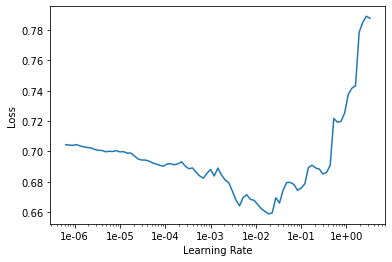

In [ ]:
learner.lr_find()
learner.recorder.plot()

In [ ]:
learner.fit_one_cycle(9,1e-2,wd=1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.112128,0.099688,0.962672,02:02
1,0.126191,0.100791,0.965172,02:01
2,0.125522,0.138115,0.955862,02:01
3,0.130525,0.165351,0.930603,02:01
4,0.108373,0.095442,0.967845,02:01
5,0.092516,0.103964,0.966293,02:01
6,0.084670,0.076320,0.973621,02:01
7,0.082096,0.074461,0.975603,02:01
8,0.075955,0.071907,0.975517,02:01


In [ ]:
def test(img,model):
  first_im = img.unsqueeze(0).to(device)
  
  output = model(first_im)
  _,pred = torch.max(output,dim=1)
  return pred[0].item()

Label female ,Predicted: female


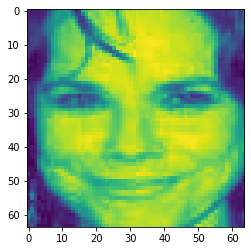

In [ ]:
img,label = test_ds[1211]
plt.imshow(img[0])
print('Label',train_ds.classes[label],',Predicted:',train_ds.classes[test(img,model)])

In [ ]:
torch.save(model.state_dict(), '/content/drive/MyDrive/gender_detect_rnn97.pth')

In [ ]:
from PIL import Image
from torchvision import transforms

In [ ]:
def predicter(root):
  model = Resnet()
  model.load_state_dict(torch.load('/content/drive/MyDrive/gender_detect_rnn97.pth'))
  model.to(device)
  model.eval()
  img = Image.open(root)
  img = img.resize((64,64))
  trans = transforms.ToTensor()
  tens_img = trans(img)
  last_img = tens_img.unsqueeze(0).to(device)
  
  output = model(last_img)
  _,pred = torch.max(output,dim=1)
  return pred[0].item()



Predicted: female


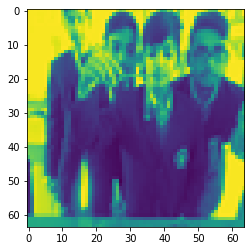

In [ ]:
root = '/content/drive/MyDrive/anky1.jpg'
image = Image.open(root)
image = image.resize((64,64))
transform = transforms.ToTensor()
tens = transform(image)
nim = tens.numpy()
plt.imshow(nim[0])

print('Predicted:',train_ds.classes[predicter(root)])
